# Binoculars score exploratory data analysis

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev

import configuration as config
import functions.data_manipulation as data_funcs

/mnt/arkk/llm_detector/llm_detector_benchmarking


## 1. Hans et al. (2024) Datasets
First, let's parse and collect the data from the original Hans et al. (2024) Binoculars publication. Get some metadata about text length and composition and get the data from all six datasets into one dataframe for easy handling.

In [2]:
# Dict describing datasets to load
hans_datasets={
    'falcon7': {
        'cc_news': 'cc_news/cc_news-falcon7.jsonl',
        'cnn': 'cnn/cnn-falcon7.jsonl',
        'pubmed': 'pubmed/pubmed-falcon7.jsonl'
    },
    'llama2-13b': {
        'cc_news': 'cc_news/cc_news-llama2_13.jsonl',
        'cnn': 'cnn/cnn-llama2_13.jsonl',
        'pubmed': 'pubmed/pubmed-llama2_13.jsonl' 
    }
}

# Output dict for collected & combined datasets
hans_data={
    'Record ID': [],
    'Generation model': [],
    'Data source': [],
    'Human text length (words)': [],
    'Human text': [],
    'Synthetic text': [],
    'Synthetic text length (words)': [],
    'Human text fraction': []
}

# Output dict for datasets wide metadata
hans_metadata={
    'Generation model': [],
    'Data source': [],
    'Records': [],
    'Mean human text length (words)': [],
    'Human text length STD': [],
    'Mean synthetic text length (words)': [],
    'Synthetic text length STD': [],
    'Mean human text fraction': []
}

# Parse, collect and combine data and get metadata
hans_metadata_df, hans_data_df=data_funcs.parse_hans_data(
    hans_datasets=hans_datasets, 
    hans_data=hans_data, 
    hans_metadata=hans_metadata,
    binoculars_data_path=config.BINOCULARS_DATA_PATH
)

Parsed falcon7, cc_news data: 1169 records
Parsed falcon7, cnn data: 876 records
Parsed falcon7, pubmed data: 112 records
Parsed llama2-13b, cc_news data: 4714 records
Parsed llama2-13b, cnn data: 2208 records
Parsed llama2-13b, pubmed data: 2198 records


Next, let's get TF-IDF across the datasets so we have some idea of the relative complexity.

In [3]:
from __future__ import annotations
from typing import Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def tf_idf(data_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''Calculates TF-IDF for human and synthetic texts from Hans data'''

    human_texts=list(data_df['Human text'])
    synthetic_texts=list(data_df['Synthetic text'])

    tfidf_vectorizer=TfidfVectorizer(input='content')

    human_tfidf_vector=tfidf_vectorizer.fit_transform(human_texts)
    human_tfidf_df = pd.DataFrame(human_tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
    synthetic_tfidf_vector=tfidf_vectorizer.fit_transform(synthetic_texts)
    synthetic_tfidf_df = pd.DataFrame(synthetic_tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    return human_tfidf_df, synthetic_tfidf_df

human_tfidf_df, synthetic_tfidf_df=tf_idf(data_df=hans_data_df)

In [4]:
human_tfidf_df.head()

,00,000,0000,00000,000000,0000000172,000001,000004496,000006,0000068,...,黃之鋒,ﬁnding,ﬁne,ﬁnely,ﬁrst,ﬂaked,ﬂour,ﬂoured,ﬂuffy,𝐤𝖔𝖇𝐲
0,0.048244,0.042917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.031481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
human_tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Columns: 175741 entries, 00 to 𝐤𝖔𝖇𝐲
dtypes: float64(175741)
memory usage: 14.8 GB


### 1.1. Hans datasets structure
Take a look at what we have:

In [6]:
# Metadata
hans_metadata_df.head(7)

,Generation model,Data source,Records,Mean human text length (words),Human text length STD,Mean synthetic text length (words),Synthetic text length STD,Mean human text fraction
0,falcon7,cc_news,1169,935.790240,775.046347,369.841610,39.872910,0.687366
1,falcon7,cnn,876,967.403429,295.668681,383.460571,26.776287,0.704008
2,falcon7,pubmed,112,2933.936937,1884.328293,336.387387,59.922703,0.861709
3,llama2-13b,cc_news,4714,863.986845,716.515544,330.481434,39.772044,0.692970
4,llama2-13b,cnn,2208,893.908473,296.323984,570.213412,133.191800,0.602143
5,llama2-13b,pubmed,2198,3257.725080,2587.036147,579.649522,130.517106,0.800563


In [7]:
# Total amounts of text
print(f"Total human text: {sum(hans_data['Human text length (words)'])} words")
print(f"Total synthetic text: {sum(hans_data['Synthetic text length (words)'])} words")
print(f"Data is {round(mean(hans_metadata_df['Mean human text fraction']) * 100, 1)}% human by words")

Total human text: 15467196 words
Total synthetic text: 4894352 words
Data is 72.5% human by words


In [8]:
# Combined dataset structure information
hans_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Record ID                      11271 non-null  int64  
 1   Generation model               11271 non-null  object 
 2   Data source                    11271 non-null  object 
 3   Human text length (words)      11271 non-null  int64  
 4   Human text                     11271 non-null  object 
 5   Synthetic text                 11271 non-null  object 
 6   Synthetic text length (words)  11271 non-null  int64  
 7   Human text fraction            11271 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 704.6+ KB


In [9]:
# Combined dataset statistics
hans_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Record ID,11271.0,1512.111170,1229.945483,2.000000,543.000000,1164.000000,2101.00000,4714.000000
Human text length (words),11271.0,1372.300240,1594.344645,143.000000,646.000000,848.000000,1320.50000,50234.000000
Synthetic text length (words),11271.0,434.242924,143.796153,1.000000,336.000000,374.000000,539.00000,1473.000000
Human text fraction,11271.0,0.698096,0.105767,0.377897,0.628042,0.685624,0.76408,0.996644


In [10]:
# Combined dataset sample
hans_data_df.head()

,Record ID,Generation model,Data source,Human text length (words),Human text,Synthetic text,Synthetic text length (words),Human text fraction
0,2,falcon7,cc_news,836,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,"$54.40, for a total value of $298,532.80. Fol...",307,0.731409
1,3,falcon7,cc_news,1153,"On Aug. 21, a solar eclipse will cut across th...",covers the sun.\nThe total eclipse will be vi...,382,0.751140
2,4,falcon7,cc_news,725,Study on Aerosol Valves Market by Infinium Glo...,of Aerosol Valves market by type (Aerosol Noz...,324,0.691134
3,5,falcon7,cc_news,689,"VICTORIA – More than 1,400 British Columbians ...",",423 illicit drug overdose deaths in 2017, up ...",373,0.648776
4,6,falcon7,cc_news,869,"On land, heatwaves can be deadly for humans an...","sometimes even larger, more mobile species of...",386,0.692430


### 1.2. Hans datasets plots
#### 1.2.1. Text length distributions

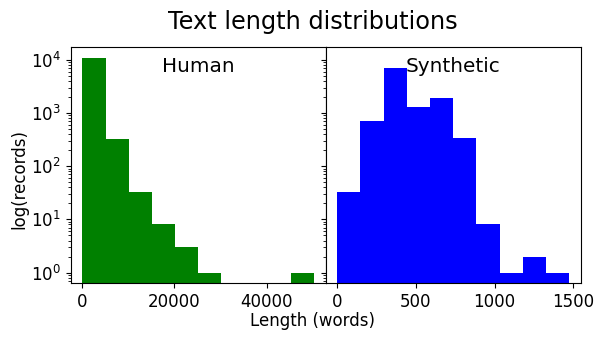

In [11]:
# Set general font size
plt.rcParams['font.size']=12

# Set-up figure and axis array
fig, axs=plt.subplots(1, 2, figsize=(6, 3), sharey='row', tight_layout=True, gridspec_kw={'wspace':0, 'hspace':0})

# Draw the histograms
axs[0].hist(hans_data_df['Human text length (words)'], facecolor='green', log=True, label='Human text')
axs[1].hist(hans_data_df['Synthetic text length (words)'], facecolor='blue', log=True, label='synthetic text')

# Annotate figure
fig.text(0.5, 1, 'Text length distributions', ha='center', fontsize='x-large')
fig.text(0.5, 0.01, 'Length (words)', ha='center')
fig.text(0.01, 0.5, 'log(records)', va='center', ha='center', rotation=90)
axs[0].set_title('Human', y=1.0, pad=-18)
axs[1].set_title('Synthetic', y=1.0, pad=-18)

plt.show()

#### 1.2.2. Human-synthetic text length correlation by record

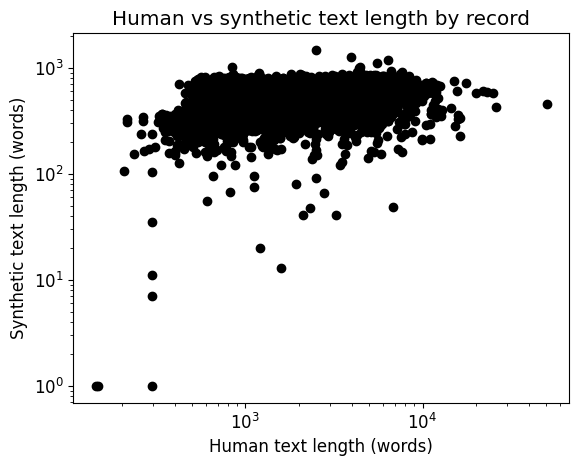

In [12]:
plt.title('Human vs synthetic text length by record')
plt.scatter(hans_data_df['Human text length (words)'], hans_data_df['Synthetic text length (words)'], color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Human text length (words)')
plt.ylabel('Synthetic text length (words)')
plt.show()

#### 1.2.3. Text composition distribution over records

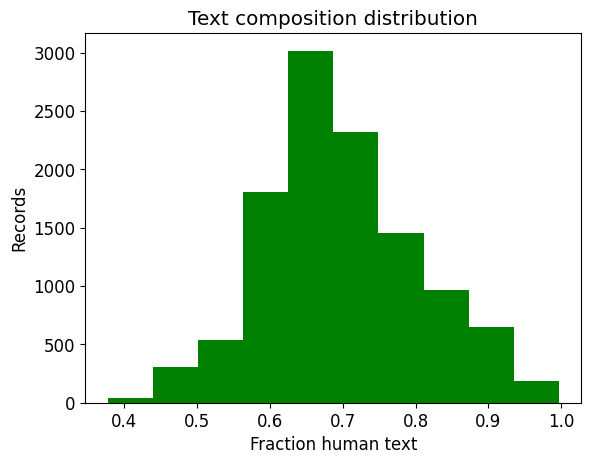

In [13]:
plt.title('Text composition distribution')
plt.hist(hans_data_df['Human text fraction'], facecolor='green')
plt.xlabel('Fraction human text')
plt.ylabel('Records')
plt.show()

#### 1.2.4. TF-IDF distributions

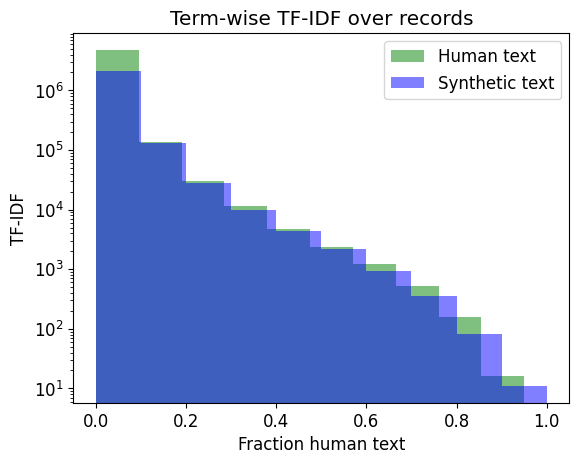

In [22]:
human_tfidfs=human_tfidf_df.to_numpy().flatten()
synthetic_tfidfs=synthetic_tfidf_df.to_numpy().flatten()

plt.title('Term-wise TF-IDF over records')
plt.hist(human_tfidfs[human_tfidfs != 0.0], log=True, facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_tfidfs[synthetic_tfidfs != 0.0], log=True, facecolor='blue', label='Synthetic text', alpha=0.5)
plt.xlabel('Fraction human text')
plt.ylabel('TF-IDF')
plt.legend(loc='upper right')
plt.show()

## 2. Binoculars scores

In [ ]:
# Load the data
data_df=pd.read_json(f'{config.BINOCULARS_DATA_PATH}/scores.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace=True)
data_df.replace('OOM', np.nan, inplace=True)
data_df.dropna(inplace=True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Binoculars score': float
})

data_df.head()

,Fragment,Fragment length (tokens),Dataset,Source,String,Observer peak memory (GB),Performer peak memory (GB),Perplexity,Cross-perplexity,Binoculars score
0,0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,8.788764,8.407716,0.971085,1.146746,0.846818
1,1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,9.313082,8.870106,1.185710,1.238428,0.957431
2,2,290,cc_news-falcon7,human,reposted in violation of US and international ...,9.649355,9.166646,1.212603,1.270731,0.954256
3,3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,7.864891,7.606767,1.285289,1.332959,0.964237
4,4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,8.818250,8.434258,1.272878,1.475142,0.862886


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37928 entries, 0 to 39230
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fragment                    37928 non-null  int64  
 1   Fragment length (tokens)    37928 non-null  int64  
 2   Dataset                     37928 non-null  object 
 3   Source                      37928 non-null  object 
 4   String                      37928 non-null  object 
 5   Observer peak memory (GB)   37928 non-null  float64
 6   Performer peak memory (GB)  37928 non-null  float64
 7   Perplexity                  37928 non-null  float64
 8   Cross-perplexity            37928 non-null  float64
 9   Binoculars score            37928 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.2+ MB


In [ ]:
datasets=data_df['Dataset'].unique()
print(f'Datasets: {datasets}')

Datasets: ['cc_news-falcon7' 'cc_news-llama2-13']


In [ ]:
human_fragments=data_df[data_df['Source'] == 'human']
synthetic_fragments=data_df[data_df['Source'] == 'synthetic']

## Perplexity vs cross-perplexity

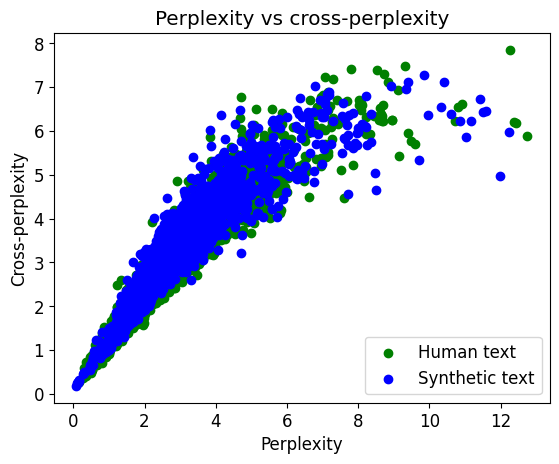

In [ ]:
plt.title('Perplexity vs cross-perplexity')
plt.scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c='green', label='Human text')
plt.scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c='blue', label='Synthetic text')
plt.legend(loc='lower right')
plt.xlabel('Perplexity')
plt.ylabel('Cross-perplexity')
plt.show()

## Binoculars score distribution

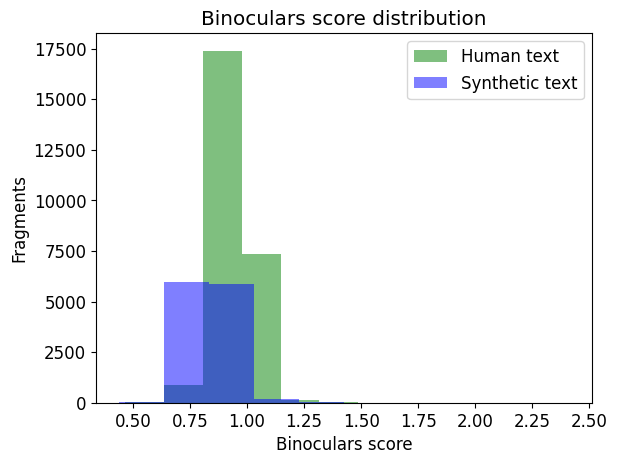

In [ ]:
plt.title('Binoculars score distribution')
plt.hist(human_fragments['Binoculars score'], facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_fragments['Binoculars score'], facecolor='blue', label='Synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Binoculars score')
plt.ylabel('Fragments')
plt.show()

## Binoculars score by fragment length

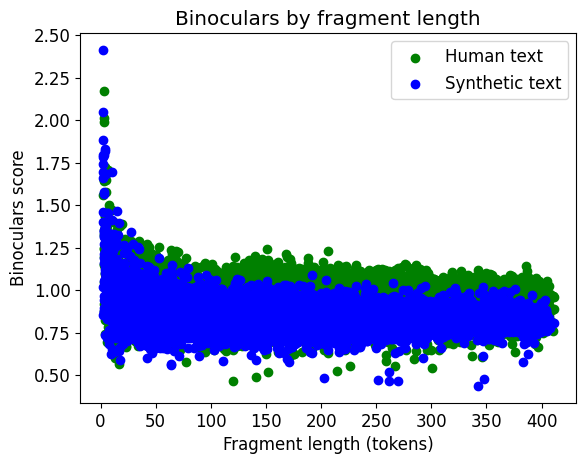

In [ ]:
plt.title('Binoculars by fragment length')
plt.scatter(human_fragments['Fragment length (tokens)'], human_fragments['Binoculars score'], c='green', label='Human text')
plt.scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Binoculars score'], c='blue', label='Synthetic text')
plt.legend(loc='upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Binoculars score')
plt.show()

## Fragment length distribution

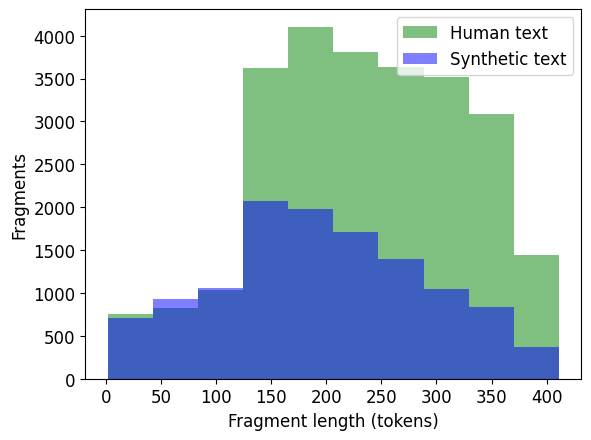

In [ ]:
plt.hist(human_fragments['Fragment length (tokens)'], facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_fragments['Fragment length (tokens)'], facecolor='blue', label='Synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Fragments')
plt.show()

## Brainstorming
Ok, let's pause for a second and think through the next move(s). Really need to get to a MVP quickly here. There is a lot of stuff that needs to be decided/figured out and I think we are in one of those situations were we need to get there to know what to focus on. It's too easy to get stuck making plots and running benchmarks - we need a path to a product that works because the meat of the challenge here is going to be figuring out how to deploy and present this thing. We can tweak the models etc. later.

I think rather than continuing to tune and tweak the back-end, what we need to do is set-up and API that computes this score. Then we can start thinking about how to present it. Here are some ideas:

1. Chat-bot/server/room - users can message the bot with text and it replies with analysis/verdict, or users just post text in a room/thread and the bot replies.
2. Web page - paste in text, get analysis.
3. Browser extension - flags synthetic text on web-pages.

I think the best/easiest way to set this up is as a messaging service. Users send text they want to test to a WhatsApp/Telegram/Discord etc. contact and the bot replies with the analysis. To start with we don't need any chat functionality or anything else, but that kind of thing would be easy to add later. Also, we already have bot code for matrix and discord which we could easily adapt for this.

OK, so what do we need? I think it's basically three things:

1. The scoring/report generation function. Takes some text, does the magic, returns the answer.
2. A flask API which exposes the scoring function - probably put all of that in a docker container.
3. A communicator bot for each text service we want to use - collects suspect text from user, calls the scoring function API, sends the answer back to the user.